# Investigating number of parameters vs. realizations in user runs

The goal of this small notebook is to gain some intuition about the configurations that users actually run ERT with. 
- How many parameters do they typically have?
- What is the ratio between the number of parameters and realzations typically?
- How many users do history matching?
- How many users use fields and surfaces?

> Query used to export `query_data.csv` 

```kusto
let ops_with_d2p = AppTraces
| where Message has "Content of the config_dict"
| where Message has "DESIGN2PARAMS"
| distinct OperationId;

AppTraces
| where not(tolower(tostring(Properties.MACHINE_USER)) == "true")
| where OperationId !in (ops_with_d2p)
| where Message startswith "Experiment summary:"
| extend Runmodel     = extract("Runmodel: (.+)", 1, Message),
         Realizations = toint(extract("Realizations: (.+)", 1, Message)),
         Parameters   = toint(extract("Parameters: (.+)", 1, Message)),
         Observations = toint(extract("Observations: (.+)", 1, Message))
| where not(tolower(tostring(Runmodel)) contains "test_run")
| where 1000 > Parameters and Parameters > 0
```

### Assumptions and background

- The query above exludes all users with more than a 1000 parameters, which in practice means that it exludes all the users that use fields and surfaces. 
- All runs using DESIGN2PARAMS were excluded, because we were unable to log the number of parameters for these runs. 
- The runs are gathered from the last 7 days on the 28-02-2026.
- Only 28 out of 528 had more than 1000 parameters.
- 304 out of 500 had zero obersvations. 
- 39 out of 539 were using DESIGN2PARAMS.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

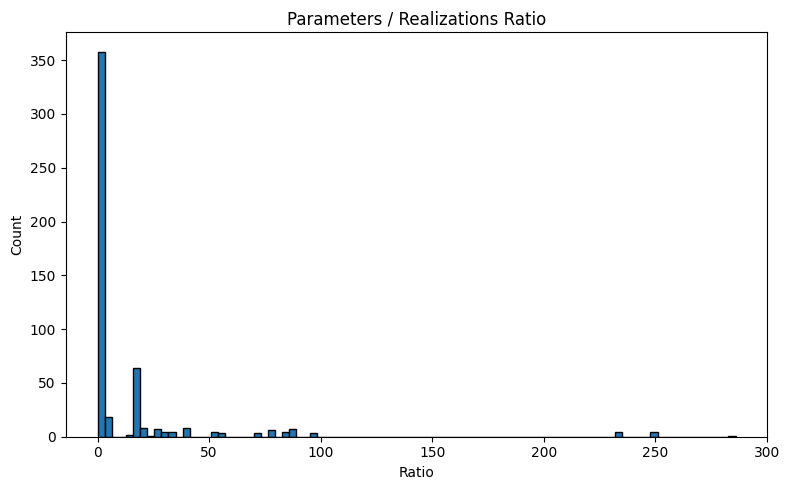

In [2]:
df = pd.read_csv("query_data.csv")

# Ensure numeric types
df["Realizations"] = pd.to_numeric(df["Realizations"], errors="coerce")
df["Parameters"] = pd.to_numeric(df["Parameters"], errors="coerce")

# Compute ratio and filter invalid entries
ratio = (df["Parameters"] / df["Realizations"]).replace(
    [float("inf"), -float("inf")], pd.NA
)
ratio = ratio.dropna()

plt.figure(figsize=(8, 5))
plt.hist(ratio, bins=90, edgecolor="black")
plt.title("Parameters / Realizations Ratio")
plt.xlabel("Ratio")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

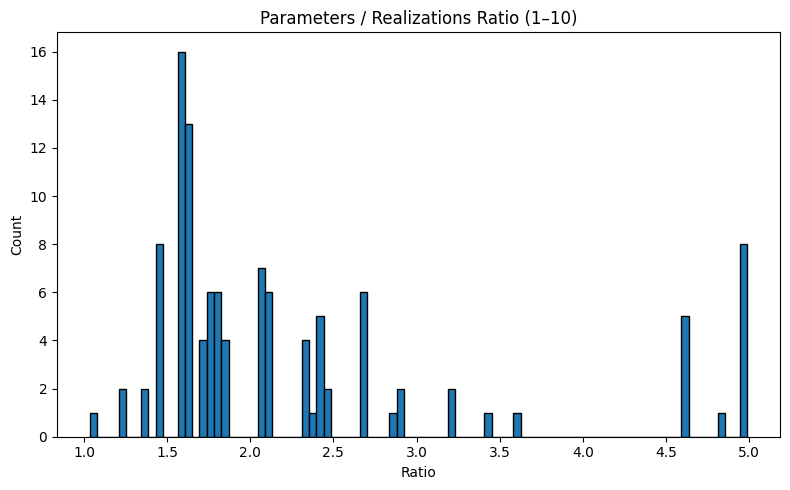

In [3]:
# Histogram of ratios between 1 and 10
ratio_1_10 = ratio[(ratio >= 1) & (ratio <= 10)]

plt.figure(figsize=(8, 5))
plt.hist(ratio_1_10, bins=90, edgecolor="black")
plt.title("Parameters / Realizations Ratio (1–10)")
plt.xlabel("Ratio")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

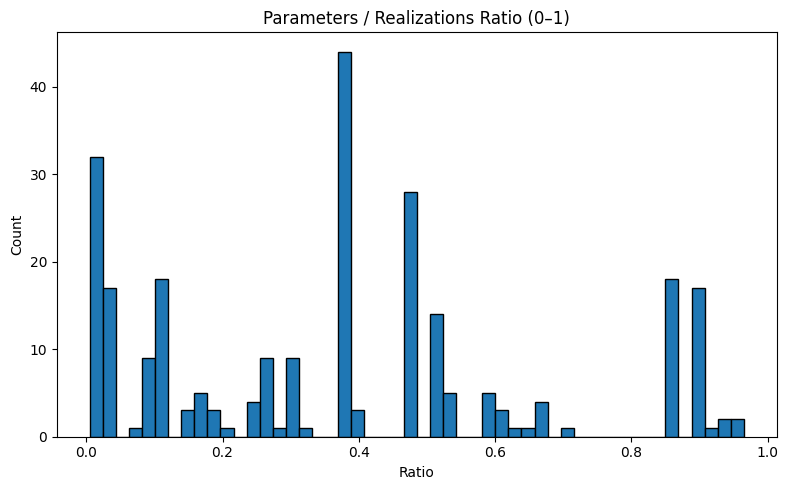

In [4]:
# Histogram of ratios between 0 and 1
ratio_0_1 = ratio[(ratio >= 0) & (ratio <= 1)]

plt.figure(figsize=(8, 5))
plt.hist(ratio_0_1, bins=50, edgecolor="black")
plt.title("Parameters / Realizations Ratio (0–1)")
plt.xlabel("Ratio")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [ ]:
# Ratio distribution statistics
total = ratio.notna().sum()

count_0_1 = ((ratio >= 0) & (ratio <= 1)).sum()
count_1_10 = ((ratio > 1) & (ratio <= 10)).sum()
count_above_10 = (ratio > 10).sum()

stats = pd.DataFrame(
    {
        "ratio": ["0–1", "1–10", ">10"],
        "count": [count_0_1, count_1_10, count_above_10],
        "percent": [
            count_0_1 / total * 100,
            count_1_10 / total * 100,
            count_above_10 / total * 100,
        ],
    }
)

stats

,range,count,percent
0,0–1,262,51.072125
1,1–10,114,22.222222
2,>10,137,26.705653


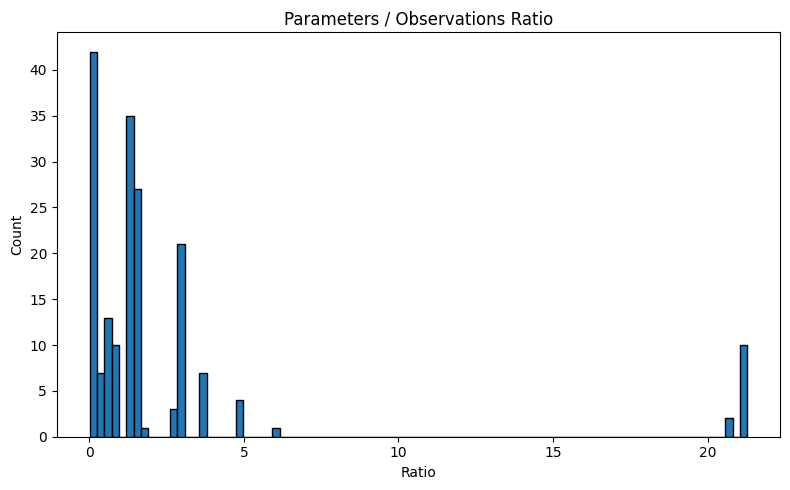

In [6]:
df["Observations"] = pd.to_numeric(df["Observations"], errors="coerce")
ratio = (df["Parameters"] / df["Observations"]).replace(
    [float("inf"), -float("inf")], pd.NA
)
ratio = ratio.dropna()

plt.figure(figsize=(8, 5))
plt.hist(ratio, bins=90, edgecolor="black")
plt.title("Parameters / Observations Ratio")
plt.xlabel("Ratio")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

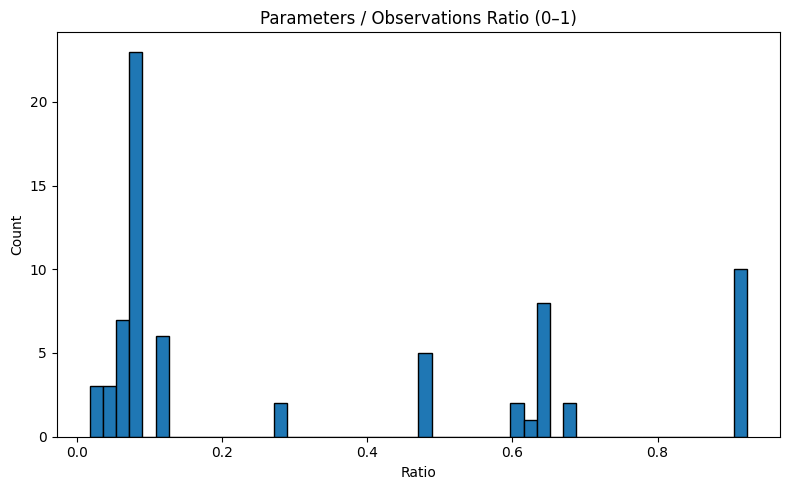

In [7]:
# Histogram of ratios between 0 and 1
ratio_0_1 = ratio[(ratio >= 0) & (ratio <= 1)]

plt.figure(figsize=(8, 5))
plt.hist(ratio_0_1, bins=50, edgecolor="black")
plt.title("Parameters / Observations Ratio (0–1)")
plt.xlabel("Ratio")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [ ]:
# Ratio distribution statistics
total = ratio.notna().sum()

count_0_1 = ((ratio >= 0) & (ratio <= 1)).sum()
count_1_10 = ((ratio > 1) & (ratio <= 10)).sum()
count_above_10 = (ratio > 10).sum()

stats = pd.DataFrame(
    {
        "ratio": ["0–1", "1–10", ">10"],
        "count": [count_0_1, count_1_10, count_above_10],
        "percent": [
            count_0_1 / total * 100,
            count_1_10 / total * 100,
            count_above_10 / total * 100,
        ],
    }
)

stats

,range,count,percent
0,0–1,72,39.344262
1,1–10,99,54.098361
2,>10,12,6.557377
